<div id="top" >
    <h3>Outline</h3>
</div>

- [Necessary Packages](#necessary_packages)
- [Global Parameters](#global_parameters)
- [Download the dataset](#download_the_dataset)
- [Load the dataset](#load_the_dataset)
- [Getting familiar with the data](#getting_familiar_with_the_data)
- [Text Cleaning](#text_cleaning)
  - [Handle repetitive characters](#handle_repetitive_characters)
  - [Managing homoglyphs](#managing_homoglyphs)
  - [Handle special entries](#handle_spetial_entries)
  - [Capitalization](#captilization)
  - [Removing punctuations](#remove_punctuation)
  - [Removing stop words](#removing_stop_words)
  - [Stemming](#stemming)
  - [Apply the transformations](#apply_the_transformations)
- [Data splitting](#data_splitting)
- [Vectorization Methods](#vectorization_methods)
- [Training](#training)
- [Word Embeddings](#word_embeddings)
  - [Word2Vec](#word2vec)
  - [Glove](#glove)
  - [Fast Text](#fast_text)
- [Training on word embeddings](#training_on_embeddings)

<div id="necessary_packages" >
    <h3>Necessary Packages</h3>
</div>

[Back to top](#top)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import requests
import re
import email_normalize
import string
import time
import warnings
from tqdm.notebook import tqdm
from textblob import Word
from unidecode import unidecode
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import word_tokenize
from gensim.models import Word2Vec,FastText
from sklearn.preprocessing import StandardScaler,FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,make_scorer
from sklearn.svm import SVC
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from word_piece_tokenizer import WordPieceTokenizer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [4]:
tqdm.pandas()
warnings.filterwarnings("ignore")

<div id="global_parameters" >
    <h3>Global Parameters</h3>
</div>

[Back to top](#top)

In [5]:
DOWNLOAD_DATASET = False
DATASET_URL = "https://raw.githubusercontent.com/GU4243-ADS/spring2018-project1-ginnyqg/master/data/spooky.csv"
DATA_DIR = os.path.join(".","data")
DATASET_PATH = os.path.join(DATA_DIR, "spooky.csv")

<div id="download_the_dataset" >
    <h3>Download the dataset</h3>
</div>

[Back to top](#top)

In [6]:
if DOWNLOAD_DATASET:
    response = requests.get(DATASET_URL)
    content = response.text
    if not os.path.isdir(DATA_DIR):
        os.mkdir(DATA_DIR)
    with open(DATASET_PATH, "w") as f:
        f.write(content)
else:
    print("Dataset download is deactivated")

Dataset download is deactivated


<div id="load_the_dataset" >
    <h3>Load the dataset</h3>
</div>

[Back to top](#top)

In [7]:
df = pd.read_csv(DATASET_PATH)

<div id="getting_familiar_with_the_data" >
    <h3>Getting familiar with the data</h3>
</div>

[Back to top](#top)

- show the columns of the dataframe

In [8]:
df.columns

Index(['id', 'text', 'author'], dtype='object')

- Check the dimensions of the dataframe

In [9]:
df.shape

(19579, 3)

- display the head and the tail of the dataframe

In [10]:
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [11]:
df.tail()

,id,text,author
19574,id17718,"I could have fancied, while I looked at it, th...",EAP
19575,id08973,The lids clenched themselves together as if in...,EAP
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP
19577,id17513,"For an item of news like this, it strikes us i...",EAP
19578,id00393,"He laid a gnarled claw on my shoulder, and it ...",HPL


- Check for missing values

In [12]:
df.isna().sum()

id        0
text      0
author    0
dtype: int64

- Checking for duplicates

In [13]:
df.duplicated().sum()

0

<div id="text_cleaning" >
    <h3>Text Cleaning</h3>
</div>

[Back to top](#top)

<div id="handle_repetitive_characters" >
    <h4>Handle repetitive characters</h4>
</div>

[Back to top](#top)

In [14]:
rx = re.compile(r'([^\W\d_])\1{2,}')

In [15]:
def remove_reptitive_characters(text):
     return re.sub(r'[^\W\d_]+', lambda x: Word(rx.sub(r'\1\1', x.group())).correct() if rx.search(x.group()) else x.group(), text)

<div id="managing_homoglyphs" >
    <h4>Managing homoglyphs</h4>
</div>

[Back to top](#top)

In [16]:
def normalaize_unicode_chars(text):
  text = unidecode(text)
  return text

<div id="handle_spetial_entries" >
    <h4>Handle special entries</h4>
</div>

[Back to top](#top)

In [17]:
def remove_html_tags(text):
    return re.sub(" +"," ",BeautifulSoup(text, 'html.parser').get_text().replace("\n"," ")).strip()

In [18]:
url_regex = "((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*"
email_regex = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'

In [19]:
def handle_special_entries(text):
  text = re.sub(url_regex, "[URL]", text)
  text = re.sub(email_regex, "[EMAIL]", text)
  text = remove_html_tags(text)
  return text

<div id="captilization" >
    <h4>Captilization</h4>
</div>

[Back to top](#top)

In [20]:
def lower(text):
    return text.lower()

<div id="remove_punctuation" >
    <h4>Remove punctuations</h4>
</div>

[Back to top](#top)

In [21]:
spetial_chars = string.punctuation
escaped_chars = [re.escape(c) for c in spetial_chars]
spetial_chars_regex = re.compile(f"({'|'.join(escaped_chars)})")

In [22]:
def remove_punctuation(text):
    return re.sub(spetial_chars_regex," ",text)

<div id="removing_stop_words" >
    <h4>Removing stop words</h4>
</div>

[Back to top](#top)

In [23]:
eng_stopwords = set(stopwords.words("english"))

In [24]:
def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in eng_stopwords]
    return ' '.join(tokens)

<div id="stemming" >
    <h4>Stemming</h4>
</div>

[Back to top](#top)

In [25]:
stemmer = SnowballStemmer(language="english")

In [26]:
def stem(text):
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

<div id="apply_the_transformations" >
    <h4>Apply the transformations</h4>
</div>

[Back to top](#top)

In [27]:
def clean(text):
    text = remove_reptitive_characters(text)
    text = normalaize_unicode_chars(text)
    text = handle_special_entries(text)
    text = lower(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = stem(text)
    return text

In [28]:
df["processed_text"] = df["text"].progress_apply(clean)

  0%|          | 0/19579 [00:00<?, ?it/s]

<div id="data_splitting" >
    <h3>Data Splitting</h3>
</div>

[Back to top](#top)

In [27]:
X = df["processed_text"]
y = df["author"]

<Axes: xlabel='author', ylabel='count'>

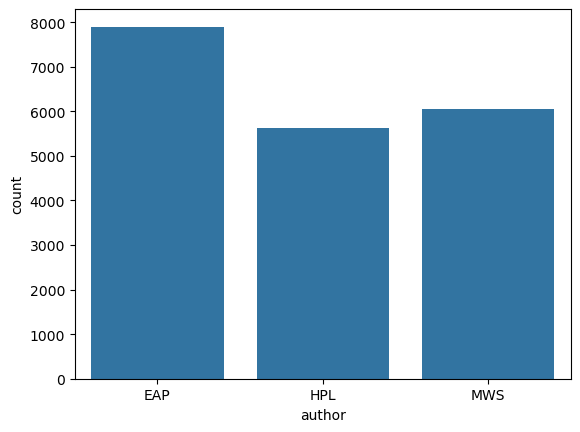

In [28]:
sns.countplot(x=y)

In [29]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=0,stratify=y)

Text(0.5, 1.0, 'Test test label distribution')

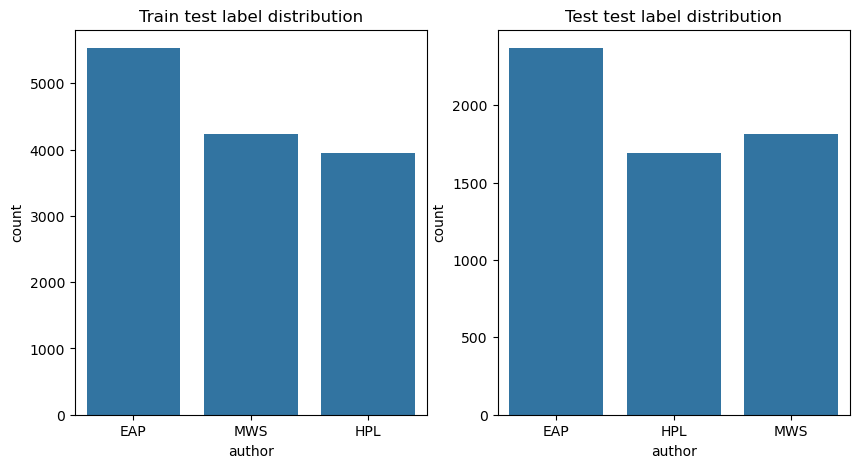

In [30]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2)

fig.set_size_inches(10,5)

sns.countplot(x=y_train,ax=ax1)
sns.countplot(x=y_test,ax=ax2)

ax1.set_title("Train test label distribution")
ax2.set_title("Test test label distribution")

<div id="vectorization_methods" >
    <h3>Vectorization Methods</h3>
</div>

[Back to top](#top)

- override the default tokenizer

In [31]:
def dummy(text):
    return text

In [32]:
def create_vectorizer(vectorizer, tokenizer):
    
    params = vectorizer.get_params()
    params['tokenizer'] = tokenizer
    params['preprocessor'] = dummy

    vectorizer.set_params(**params)

    return vectorizer

- rule based

In [33]:
def make_tokenizer():

    nlp = English()
    tokenizer = Tokenizer(nlp.vocab)

    return tokenizer

In [34]:
rule_based_tokenizer = make_tokenizer()

In [35]:
def rulebased(text):
    return [str(token) for token in rule_based_tokenizer(text)]

- word piece

In [36]:
wordpiece_tokenizer = WordPieceTokenizer()

In [37]:
def wordpiece(text):
    ids = wordpiece_tokenizer.tokenize(text)
    return wordpiece_tokenizer.convert_ids_to_tokens(ids)

- define the vectorizers

In [38]:
cv_space_based = create_vectorizer(CountVectorizer(), tokenizer=word_tokenize)
tfidf_space_based = create_vectorizer(TfidfVectorizer(), tokenizer=word_tokenize)
one_hot_space_based = create_vectorizer(CountVectorizer(binary=True), tokenizer=word_tokenize)

cv_wordpiece = create_vectorizer(CountVectorizer(), tokenizer=wordpiece)
tfidf_wordpiece = create_vectorizer(TfidfVectorizer(), tokenizer=wordpiece)
one_hot_wordpiece = create_vectorizer(CountVectorizer(binary=True), tokenizer=wordpiece)

cv_rule_based = create_vectorizer(CountVectorizer(), tokenizer=rulebased)
tfidf_rule_based = create_vectorizer(TfidfVectorizer(), tokenizer=rulebased)
one_hot_rule_based = create_vectorizer(CountVectorizer(binary=True), tokenizer=rulebased)

- Test the vectorization techniques on a simple dataset

In [39]:
_X = [
    "i love natural language processing",
    "i am studying natural language processing",
    "i love natural language processing, i am studying natural language processing",
]

In [40]:
def test_vectorizer(X, vectorizer):
    vectorizer.fit(X)
    data = vectorizer.transform(X).toarray()
    features = vectorizer.get_feature_names_out()
    return pd.DataFrame(data=data,columns=features)

In [41]:
test_vectorizer(_X, cv_space_based)

,",",am,i,language,love,natural,processing,studying
0,0,0,1,1,1,1,1,0
1,0,1,1,1,0,1,1,1
2,1,1,2,2,1,2,2,1


In [42]:
test_vectorizer(_X, tfidf_space_based)

,",",am,i,language,love,natural,processing,studying
0,0.000000,0.000000,0.420401,0.420401,0.541343,0.420401,0.420401,0.000000
1,0.000000,0.476063,0.369705,0.369705,0.000000,0.369705,0.369705,0.476063
2,0.346762,0.263721,0.409606,0.409606,0.263721,0.409606,0.409606,0.263721


In [43]:
test_vectorizer(_X, one_hot_space_based)

,",",am,i,language,love,natural,processing,studying
0,0,0,1,1,1,1,1,0
1,0,1,1,1,0,1,1,1
2,1,1,1,1,1,1,1,1


In [44]:
test_vectorizer(_X, cv_wordpiece)

,",",[CLS],[SEP],am,i,language,love,natural,processing,studying
0,0,1,1,0,1,1,1,1,1,0
1,0,1,1,1,1,1,0,1,1,1
2,1,1,1,1,2,2,1,2,2,1


In [45]:
test_vectorizer(_X, tfidf_wordpiece)

,",",[CLS],[SEP],am,i,language,love,natural,processing,studying
0,0.000000,0.361359,0.361359,0.000000,0.361359,0.361359,0.465315,0.361359,0.361359,0.000000
1,0.000000,0.327627,0.327627,0.421879,0.327627,0.327627,0.000000,0.327627,0.327627,0.421879
2,0.333073,0.196718,0.196718,0.253310,0.393436,0.393436,0.253310,0.393436,0.393436,0.253310


In [46]:
test_vectorizer(_X, one_hot_wordpiece)

,",",[CLS],[SEP],am,i,language,love,natural,processing,studying
0,0,1,1,0,1,1,1,1,1,0
1,0,1,1,1,1,1,0,1,1,1
2,1,1,1,1,1,1,1,1,1,1


In [47]:
test_vectorizer(_X, cv_rule_based)

,am,i,language,love,natural,processing,"processing,",studying
0,0,1,1,1,1,1,0,0
1,1,1,1,0,1,1,0,1
2,1,2,2,1,2,1,1,1


In [48]:
test_vectorizer(_X, tfidf_rule_based)

,am,i,language,love,natural,processing,"processing,",studying
0,0.000000,0.420401,0.420401,0.541343,0.420401,0.420401,0.000000,0.000000
1,0.476063,0.369705,0.369705,0.000000,0.369705,0.369705,0.000000,0.476063
2,0.282064,0.438096,0.438096,0.282064,0.438096,0.219048,0.370881,0.282064


In [49]:
test_vectorizer(_X, one_hot_rule_based)

,am,i,language,love,natural,processing,"processing,",studying
0,0,1,1,1,1,1,0,0
1,1,1,1,0,1,1,0,1
2,1,1,1,1,1,1,1,1


<div id="training" >
    <h3>Training</h3>
</div>

[Back to top](#top)

- models creation

In [50]:
models = {}

In [51]:
models["MLP Classifier + Bag of words + Space Based Tokenization"] = Pipeline(steps=[
    ("Feature Extraction", create_vectorizer(CountVectorizer(), tokenizer=word_tokenize)),
    ("Estimator", MLPClassifier(hidden_layer_sizes=(8,),learning_rate_init=0.01,alpha=0.5))
])

In [52]:
models["MLP Classifier + TfIdf + Space Based Tokenization"] = Pipeline(steps=[
    ("Feature Extraction", create_vectorizer(TfidfVectorizer(), tokenizer=word_tokenize)),
    ("Estimator", MLPClassifier(hidden_layer_sizes=(8,),learning_rate_init=0.01,alpha=0.5))
])

In [53]:
models["MLP Classifier + One Hot + Space Based Tokenization"] = Pipeline(steps=[
    ("Feature Extraction", create_vectorizer(CountVectorizer(binary=True), tokenizer=word_tokenize)),
    ("Estimator", MLPClassifier(hidden_layer_sizes=(8,),learning_rate_init=0.01,alpha=0.5))
])

In [54]:
models["MLP Ckassifier + Bag of words + WordPiece Tokenization"] = Pipeline(steps=[
    ("Feature Extraction", create_vectorizer(CountVectorizer(), tokenizer=wordpiece)),
    ("Estimator", MLPClassifier(hidden_layer_sizes=(8,),learning_rate_init=0.01,alpha=0.5))
])

In [55]:
models["MLP Ckassifier + TfIdf + WordPiece Tokenization"] = Pipeline(steps=[
    ("Feature Extraction", create_vectorizer(TfidfVectorizer(), tokenizer=wordpiece)),
    ("Estimator", MLPClassifier(hidden_layer_sizes=(8,),learning_rate_init=0.01,alpha=0.5))
])

In [56]:
models["MLP Classifier + One hot + WordPiece Tokenization"] = Pipeline(steps=[
    ("Feature Extraction", create_vectorizer(CountVectorizer(binary=True), tokenizer=wordpiece)),
    ("Estimator", MLPClassifier(hidden_layer_sizes=(8,),learning_rate_init=0.01,alpha=0.5))
])

In [57]:
models["MLP Classifier + Bag of words + Rule Based Tokenization"] = Pipeline(steps=[
    ("Feature Extraction", create_vectorizer(CountVectorizer(), tokenizer=rulebased)),
    ("Estimator", MLPClassifier(hidden_layer_sizes=(8,),learning_rate_init=0.01,alpha=0.5))
])

In [58]:
models["MLP Classifier + TfIdf + Rule Based Tokenization"] = Pipeline(steps=[
    ("Feature Extraction", create_vectorizer(TfidfVectorizer(), tokenizer=rulebased)),
    ("Estimator", MLPClassifier(hidden_layer_sizes=(8,),learning_rate_init=0.01,alpha=0.5))
])

In [59]:
models["MLP Classifier + One hot + Rule Based Tokenization"] = Pipeline(steps=[
    ("Feature Extraction", create_vectorizer(CountVectorizer(binary=True), tokenizer=rulebased)),
    ("Estimator", MLPClassifier(hidden_layer_sizes=(8,),learning_rate_init=0.01,alpha=0.5))
])

- Define the metrics

In [60]:
def f1_macro(y, y_hat):
    return f1_score(y, y_hat, average='macro')

In [61]:
def precision_macro(y, y_hat):
    return precision_score(y, y_hat, average='macro')

In [62]:
def recall_macro(y, y_hat):
    return recall_score(y, y_hat, average='macro')

In [63]:
metrics = {
    "accuracy":accuracy_score,
    "f1 score":f1_macro,
    "precision":precision_macro,
    "recall":recall_macro
}

- training

In [64]:
def train(X, y, metrics, models):
    results = {}

    for model in models.keys():
        results[model] = []

    for model_name, model in models.items():

        print(f"--- {model_name} ---")
        tic = time.time()
        model.fit(X, y)
        toc = time.time()
        
        y_hat = model.predict(X)
        
        for metric_name, metric in metrics.items():
            score = metric(y, y_hat)
            results[model_name].append(score)

        results[model_name].append(int((toc - tic) * 1000) / 1000)

    index = list(metrics.keys()) + ['fit time (in seconds)']
    return pd.DataFrame(results, index=index).transpose()

In [65]:
train(X_train,y_train,metrics, models)

--- MLP Classifier + Bag of words + Space Based Tokenization ---
--- MLP Classifier + TfIdf + Space Based Tokenization ---
--- MLP Classifier + One Hot + Space Based Tokenization ---
--- MLP Ckassifier + Bag of words + WordPiece Tokenization ---
--- MLP Ckassifier + TfIdf + WordPiece Tokenization ---
--- MLP Classifier + One hot + WordPiece Tokenization ---
--- MLP Classifier + Bag of words + Rule Based Tokenization ---
--- MLP Classifier + TfIdf + Rule Based Tokenization ---
--- MLP Classifier + One hot + Rule Based Tokenization ---


,accuracy,f1 score,precision,recall,fit time (in seconds)
MLP Classifier + Bag of words + Space Based Tokenization,0.942284,0.942470,0.945334,0.940228,35.060
MLP Classifier + TfIdf + Space Based Tokenization,0.923313,0.923031,0.924880,0.921441,37.089
MLP Classifier + One Hot + Space Based Tokenization,0.941262,0.941447,0.944229,0.939583,37.143
MLP Ckassifier + Bag of words + WordPiece Tokenization,0.911784,0.911918,0.915950,0.908900,36.348
MLP Ckassifier + TfIdf + WordPiece Tokenization,0.887049,0.886746,0.893596,0.882198,35.883
MLP Classifier + One hot + WordPiece Tokenization,0.916016,0.915994,0.918478,0.914027,23.038
MLP Classifier + Bag of words + Rule Based Tokenization,0.943524,0.943680,0.946917,0.941113,43.870
MLP Classifier + TfIdf + Rule Based Tokenization,0.926888,0.926983,0.926865,0.927553,47.641
MLP Classifier + One hot + Rule Based Tokenization,0.943378,0.943773,0.949149,0.939911,35.389


- Evaluation

In [66]:
def evaluate(X, y, metrics, models):

    results = {}

    for model in models.keys():
        results[model] = []

    for model_name, model in models.items():
        
        y_hat = model.predict(X)
        
        for metric_name, metric in metrics.items():
            score = metric(y, y_hat)
            results[model_name].append(score)

    return pd.DataFrame(results, index=metrics.keys()).transpose()

In [67]:
evaluate(X_test,y_test,metrics, models)

,accuracy,f1 score,precision,recall
MLP Classifier + Bag of words + Space Based Tokenization,0.794178,0.792677,0.798888,0.788664
MLP Classifier + TfIdf + Space Based Tokenization,0.807627,0.805861,0.811721,0.801969
MLP Classifier + One Hot + Space Based Tokenization,0.791624,0.789802,0.796188,0.786075
MLP Ckassifier + Bag of words + WordPiece Tokenization,0.769663,0.768077,0.774199,0.764098
MLP Ckassifier + TfIdf + WordPiece Tokenization,0.777154,0.775518,0.788336,0.768762
MLP Classifier + One hot + WordPiece Tokenization,0.775111,0.773856,0.778990,0.770380
MLP Classifier + Bag of words + Rule Based Tokenization,0.791284,0.789078,0.799472,0.783567
MLP Classifier + TfIdf + Rule Based Tokenization,0.799796,0.798756,0.800740,0.798554
MLP Classifier + One hot + Rule Based Tokenization,0.789241,0.786963,0.798203,0.780910


<div id="word_embeddings" >
    <h3>Word Embeddings</h3>
</div>

[Back to top](#top)

In [68]:
def make_vectorizer(func, print_ = True):

    def transform(docs):

        if print_:
            print("Begin Vectorization")
        
        if isinstance(docs, pd.Series):
            docs = docs.values

        transformed_docs = []

        for doc in docs:
            transformed_docs.append(func(doc))

        if print_:
            print("End Vectorization")
            
        return np.array(transformed_docs)

    return FunctionTransformer(func=transform)

<div id="word2vec" >
    <h4>Word2Vec</h4>
</div>

[Back to top](#top)

In [69]:
data = df['processed_text'].progress_apply(word_tokenize)

  0%|          | 0/19579 [00:00<?, ?it/s]

- Continuous Bag of words

In [70]:
cbow = Word2Vec(data, min_count=1,vector_size=100, window=5)

In [71]:
def text2CBOW(text):
    
    if len(text) == 0:
        return np.zeros((cbow.vector_size,))

    tokens = word_tokenize(text)
    return cbow.wv.get_mean_vector(tokens)

- Skip n-grams

In [72]:
sg = Word2Vec(data, min_count=1,vector_size=100, window=5, sg=1)

In [73]:
def text2SG(text):
    
    if len(text) == 0:
        return np.zeros((cbow.vector_size,))

    tokens = word_tokenize(text)
    return sg.wv.get_mean_vector(tokens)

<div id="glove" >
    <h4>Glove</h4>
</div>

[Back to top](#top)

In [74]:
def load_vectors(path=os.path.join(".","glove.6B","glove.6B.100d.txt")):

    embeddings = {}

    with open(path, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vec = np.asarray(values[1:], "float32")
            embeddings[word] = vec

    return embeddings

In [75]:
embeddings = load_vectors()

In [76]:
def text2Glove(text):
    
    tokens = word_tokenize(text)

    key = next(iter(embeddings.keys()))
    dim = embeddings[key].shape
    default_vec = np.zeros(shape=(dim))

    mean_vec = default_vec

    for token in tokens:
        mean_vec += embeddings.get(token, default_vec)

    return mean_vec / max(len(tokens), 1)

<div id="fast_text" >
    <h4>Fast Text</h4>
</div>

[Back to top](#top)

In [77]:
fs = FastText(data, min_count=1,vector_size=100,window=5)

In [78]:
def text2FS(text):
    
    tokens = word_tokenize(text)

    key = next(iter(embeddings.keys()))
    dim = embeddings[key].shape
    default_vec = np.zeros(shape=(dim))

    mean_vec = default_vec

    for token in tokens:
        mean_vec += fs.wv[token]

    return mean_vec / max(len(tokens), 1)

<div  id="training_on_embeddings" >
    <h3>Training on word embeddings</h3>
</div>

[Back to top](#top)

- define the models

In [79]:
wv_models = {}

In [80]:
wv_models["MLP Classifier + Continuous Bag Of Words"] = Pipeline(steps=[
    ("Vectorizer", make_vectorizer(text2CBOW)),
    ("Scaler", StandardScaler()),
    ("Estimator", MLPClassifier(hidden_layer_sizes=(32,)))
])

In [81]:
wv_models["MLP Classifier + Skip n-grams"] = Pipeline(steps=[
    ("Vectorizer", make_vectorizer(text2SG)),
    ("Scaler", StandardScaler()),
    ("Estimator",MLPClassifier(hidden_layer_sizes=(32,)))
])

In [82]:
wv_models["MLP Classifier + Glove"] = Pipeline(steps=[
    ("Vectorizer", make_vectorizer(text2Glove)),
    ("Scaler", StandardScaler()),
    ("Estimator", MLPClassifier(hidden_layer_sizes=(32,)))
])

In [83]:
wv_models["MLP Classifier + Fast Text"] = Pipeline(steps=[
    ("Vectorizer", make_vectorizer(text2FS)),
    ("Scaler", StandardScaler()),
    ("Estimator", MLPClassifier(hidden_layer_sizes=(32,)))
])

- train the models

In [84]:
train(X_train,y_train,metrics,wv_models)

--- MLP Classifier + Continuous Bag Of Words ---
Begin Vectorization
End Vectorization
Begin Vectorization
End Vectorization
--- MLP Classifier + Skip n-grams ---
Begin Vectorization
End Vectorization
Begin Vectorization
End Vectorization
--- MLP Classifier + Glove ---
Begin Vectorization
End Vectorization
Begin Vectorization
End Vectorization
--- MLP Classifier + Fast Text ---
Begin Vectorization
End Vectorization
Begin Vectorization
End Vectorization


,accuracy,f1 score,precision,recall,fit time (in seconds)
MLP Classifier + Continuous Bag Of Words,0.725648,0.722777,0.724984,0.721174,26.291
MLP Classifier + Skip n-grams,0.773440,0.773157,0.772500,0.773881,25.197
MLP Classifier + Glove,0.403575,0.191832,0.467844,0.333412,4.150
MLP Classifier + Fast Text,0.629478,0.619941,0.633250,0.616574,20.589


In [85]:
evaluate(X_test,y_test,metrics,wv_models)

Begin Vectorization
End Vectorization
Begin Vectorization
End Vectorization
Begin Vectorization
End Vectorization
Begin Vectorization
End Vectorization


,accuracy,f1 score,precision,recall
MLP Classifier + Continuous Bag Of Words,0.536261,0.531248,0.532149,0.530967
MLP Classifier + Skip n-grams,0.694757,0.694340,0.694340,0.694595
MLP Classifier + Glove,0.403473,0.191655,0.134491,0.333333
MLP Classifier + Fast Text,0.595165,0.584620,0.600438,0.581706
